In [1]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#import skvideo.io as vidio
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py
#from tabulate import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as tF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
#from torchviz import make_dot
#from torchsummary import summary

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from collections import OrderedDict 

from sklearn.manifold import TSNE


In [2]:
torch.manual_seed(0)

In [3]:
# set device
if torch.cuda.is_available():
    print('Using GPU')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU


In [4]:
# Settings
settings = {
    'batch_size': 256,
    'epochs': 10,
    'learning_rate': 0.001,
}

In [5]:
# DataLoader
train_set = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_set = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

train_batch = DataLoader(train_set, batch_size=settings['batch_size'], shuffle=False)
test_batch = DataLoader(test_set, batch_size=settings['batch_size'], shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
images = train_batch.dataset.data
labels = train_batch.dataset.targets
test_images = test_batch.dataset.data
test_labels = test_batch.dataset.targets

print(images.shape, test_images.shape)


(50000, 32, 32, 3) (10000, 32, 32, 3)


In [7]:
trimages = train_batch.dataset.data
tsimages = test_batch.dataset.data

In [8]:
labels = np.int_(labels)
test_labels = np.int_(test_labels)

In [9]:
lab_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

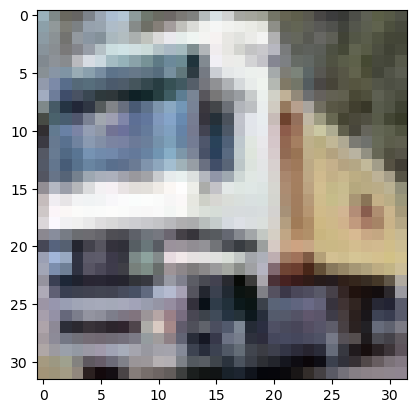

truck


In [10]:
plt.imshow(train_batch.dataset.data[1]/255.0)
plt.show()
print(lab_dict[labels[1]])

In [11]:
class Cutout(nn.Module):
    def __init__(self, seed = 0):
        self.seed = seed
        
    def get_start_index(self,L):
        return np.random.randint(L)
    
    def __call__(self,frame):
        channels, h, w = frame.shape
        #print(frames.shape)
        size = h//4
        n_squares = np.random.randint(1,3,1)[0]
        new_image = frame
        for _ in range(n_squares):
            y = np.clip(self.get_start_index(h), size // 2, h - size//2)
            x = np.clip(self.get_start_index(w), size // 2, w - size//2)
            
            y1 = np.clip(y - size // 2, 0, h)
            y2 = np.clip(y + size // 2, 0, h)
            x1 = np.clip(x - size // 2, 0, w)
            x2 = np.clip(x + size // 2, 0, w)
            new_image[:, y1:y2,x1:x2] = 0
        return new_image

In [12]:
class AddGaussianNoise(nn.Module):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [13]:
images = images.transpose(0,3,1,2)

MEAN = np.mean(images[:40000]/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(images[:40000]/255.0,axis=(0,2,3),keepdims=True)

In [14]:
class C10DataGen(Dataset):
    def __init__(self,phase,imgarr,s = 0.5):
        self.phase = phase
        self.imgarr = imgarr
        self.s = s
        self.transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                              transforms.RandomResizedCrop(32,(0.8,1.0)),
                                              transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.2*self.s)], p = 0.8),
                                                                  transforms.RandomGrayscale(p=0.2)
                                                                 ])])

    def __len__(self):
        return self.imgarr.shape[0]

    def __getitem__(self,idx):
        
        x = self.imgarr[idx] 
        #print(x.shape)
        x = x.astype(np.float32)/255.0

        x1 = self.augment(torch.from_numpy(x))
        x2 = self.augment(torch.from_numpy(x))
        
        x1 = self.preprocess(x1)
        x2 = self.preprocess(x2)
        
        return x1, x2

    #shuffles the dataset at the end of each epoch
    def on_epoch_end(self):
        self.imgarr = self.imgarr[random.sample(population = list(range(self.__len__())),k = self.__len__())]

    def preprocess(self,frame):
        frame = (frame-MEAN)/STD
        return frame
    
    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self, frame, transformations = None):
        
        if self.phase == 'train':
            frame = self.transforms(frame)
        else:
            return frame
        
        return frame

In [15]:

dg = C10DataGen('train',images) #train_df)
print(images.shape)
dl = DataLoader(dg,batch_size = 256)


(50000, 3, 32, 32)


e:\Anaconda\envs\snk\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


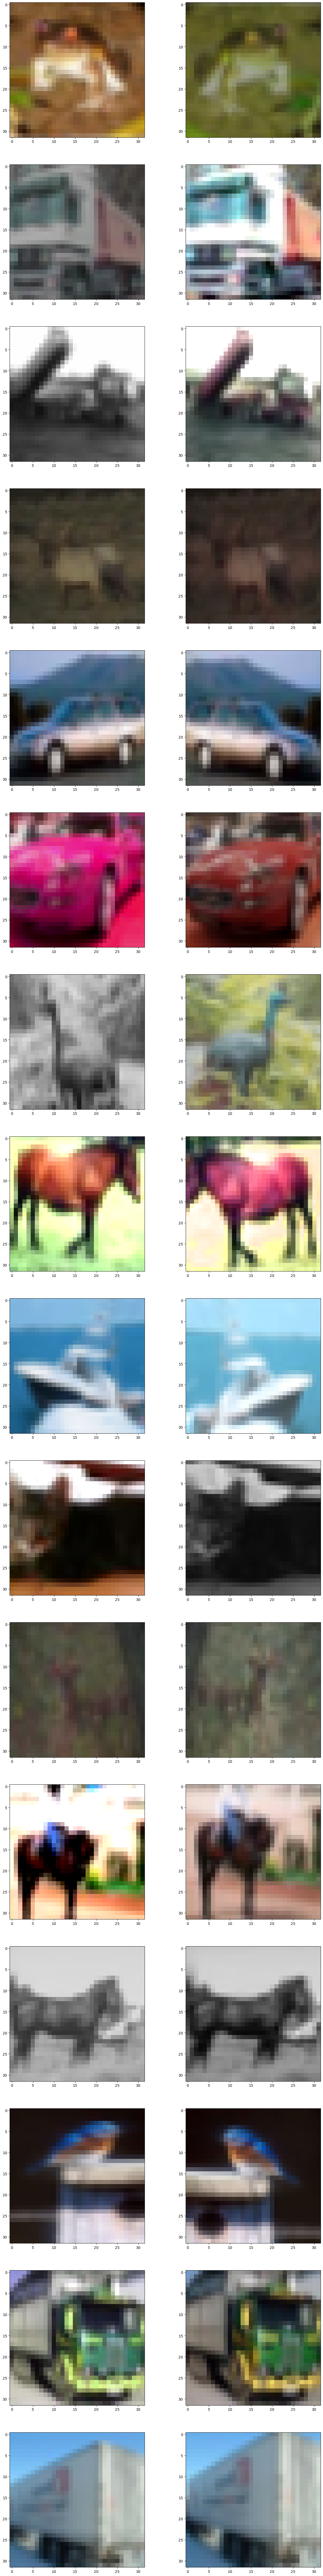

In [16]:
#MEAN = np.array([0.485, 0.456, 0.406]).reshape((1,1,3))
#STD = np.array([0.229, 0.224, 0.25]).reshape((1,1,3))
fig,axs = plt.subplots(16,2,figsize=(16,128))
row = 0
col = 0
for step,(x1,x2) in enumerate(dl):
    # change shape
    for i in range(16):
        #print(x1[i]*STD + MEAN)
        #print(x2[i]*STD + MEAN)
        axs[i,0].imshow((x1[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
        axs[i,1].imshow((x2[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
    break

In [17]:
# define the model where there is a resnet18 backbone and a linear head
class C10Model(nn.Module):
    def __init__(self):
        super(C10Model,self).__init__()
        self.pretrained = models.resnet18(pretrained=True)
        # self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        
        self.encoder = nn.Sequential(
            nn.Linear(1000,512),
            nn.ReLU(),
            nn.Linear(512,512),
        )
        
    def forward(self,x):
        out = self.pretrained(x)
        out = self.encoder(torch.squeeze(out))
        return out

In [18]:
model = C10Model()
model.to(device)

e:\Anaconda\envs\snk\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\snk\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


C10Model(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [19]:
x = np.random.random((32,3,224,224))
print(x.shape)

(32, 3, 224, 224)


In [20]:
out = model(torch.tensor(x, device = device, dtype = torch.float32))

In [21]:
out[0].shape, out[1].shape

(torch.Size([512]), torch.Size([512]))

In [22]:
def load_optimizer(arg_optimizer, model, batch_size):

    scheduler = None
    if arg_optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # TODO: LARS
    elif arg_optimizer == "LARS":
        # optimized using LARS with linear learning rate scaling
        # (i.e. LearningRate = 0.3 × BatchSize/256) and weight decay of 10−6.
        learning_rate = 0.3 * batch_size / 256
        optimizer = LARS(
            [params for params in model.parameters() if params.requires_grad],
            lr=0.1,
            weight_decay=1e-6,
            exclude_from_weight_decay=["batch_normalization", "bias"],
        )

        # "decay the learning rate with the cosine decay schedule without restarts"
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, epochs, eta_min=0, last_epoch=-1
        )
    else:
        raise NotImplementedError

    return optimizer, scheduler

def save_model(model, optimizer, scheduler, current_epoch, name):
    out = os.path.join('saved_models/',name.format(current_epoch))

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict':scheduler.state_dict()}, out)

In [23]:
!mkdir saved_models

A subdirectory or file saved_models already exists.


In [24]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)
        
        self.tot_neg = 0

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        N = 2 * self.batch_size #* self.world_size
        
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        #print(sim.shape)

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [25]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

In [26]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 00000: adjusting learning rate of group 0 to 2.0000e-01.


In [27]:
criterion = SimCLR_Loss(batch_size = 128, temperature = 0.5)

In [28]:
trimages = images[:40000]
valimages = images[40000:]
trlabels = labels[:40000]
vallabels = labels[40000:]
print(trimages.shape)
print(valimages.shape)


(40000, 3, 32, 32)
(10000, 3, 32, 32)


In [29]:
dg = C10DataGen('train',trimages)#train_df)
dl = DataLoader(dg,batch_size = 128,drop_last=True)

In [30]:
vdg = C10DataGen('valid',valimages)#_df)
vdl = DataLoader(vdg,batch_size = 128,drop_last=True)

(array([1014., 1014.,  952., 1016.,  997., 1025.,  980.,  977., 1003.,
        1022.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

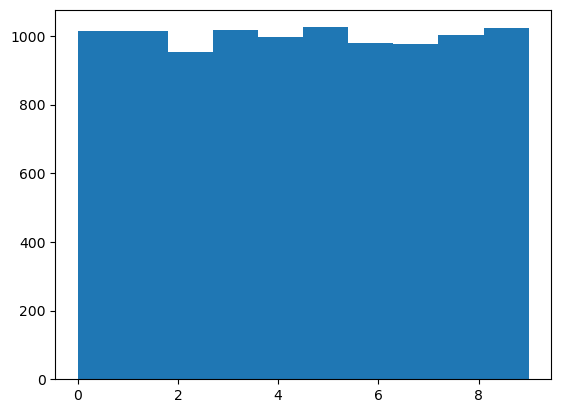

In [31]:
plt.hist(vallabels)

In [32]:
nr = 0
global_step = 0
current_epoch = 0
epochs = 1

In [33]:
def plot_features(model, num_classes, num_feats, batch_size, val_df = None):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for x1,x2 in vdl:
            x1 = x1.squeeze().to(device = device, dtype = torch.float)#.view((-1,3,224,224))
            #y = y.to(device = 'cuda:0')#.view((-1,1))
            out = model(x1)
            out = out.cpu().data.numpy()#.reshape((1,-1))
            feats = np.append(feats,out,axis = 0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    #plt.scatter(x_feats[:,1],x_feats[:,0])
    num_samples = int(batch_size*(valimages.shape[0]//batch_size))#(len(val_df)
    
    for i in range(num_classes):
        #plt.scatter(x_feats[val_df['class'].iloc[:num_samples].values==i,1],x_feats[val_df['class'].iloc[:num_samples].values==i,0])
        plt.scatter(x_feats[vallabels[:num_samples]==i,1],x_feats[vallabels[:num_samples]==i,0])
    
    plt.legend([str(i) for i in range(num_classes)])
    plt.show()

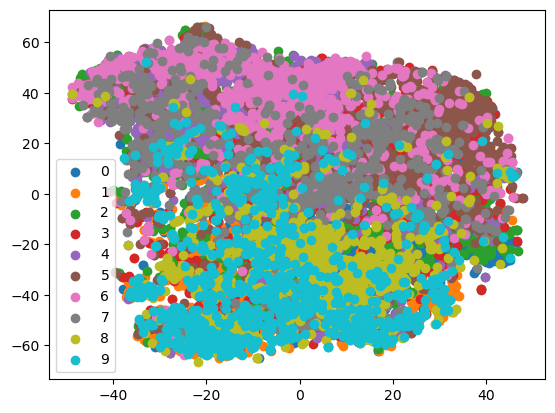

In [34]:
plot_features(model, 10, 512, 128)

In [35]:
def train(train_loader, model, criterion, optimizer):
    loss_epoch = 0
    print('train')
    for step, (x_i, x_j) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = x_i.squeeze().to(device).float()
        x_j = x_j.squeeze().to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        # if nr == 0 and step % 50 == 0:
        print(f"Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [36]:
def valid(valid_loader, model, criterion):
    loss_epoch = 0
    print('valid')
    for step, (x_i, x_j) in enumerate(valid_loader):
        
        x_i = x_i.squeeze().to(device).float()
        x_j = x_j.squeeze().to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        
        print(f"Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [41]:
tr_loss = []
val_loss = []

In [38]:
for epoch in range(epochs):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    tr_loss_epoch = train(dl, model, criterion, optimizer)

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()
    
    lr = optimizer.param_groups[0]["lr"]

    if nr == 0 and (epoch+1) % 50 == 0:
        save_model(model, optimizer, mainscheduler, current_epoch,"SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

    model.eval()
    with torch.no_grad():
        val_loss_epoch = valid(vdl, model, criterion)

    if nr == 0:
        
        tr_loss.append(tr_loss_epoch / len(dl))
        
        val_loss.append(val_loss_epoch / len(vdl))
        
        print(
            f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dl)}\t lr: {round(lr, 5)}"
        )
        print(
            f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vdl)}\t lr: {round(lr, 5)}"
        )
        current_epoch += 1

    dg.on_epoch_end()

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    if (epoch+1)%10==0:
        plot_features(model.backbone, 10, 512, 128) #, valimages)

## end training
save_model(model, optimizer, mainscheduler, current_epoch, "SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

Epoch [0/1]	
train


e:\Anaconda\envs\snk\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\runef\AppData\Local\Temp\ipykernel_21232\1065139194.py:129: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at C:\cb\pytorch_1

Step [0/312]	 Loss: 5.23535
Step [1/312]	 Loss: 5.21791
Step [2/312]	 Loss: 5.13931
Step [3/312]	 Loss: 5.1831
Step [4/312]	 Loss: 5.13194
Step [5/312]	 Loss: 5.11204
Step [6/312]	 Loss: 5.1747
Step [7/312]	 Loss: 5.15305
Step [8/312]	 Loss: 5.04603
Step [9/312]	 Loss: 5.16371
Step [10/312]	 Loss: 5.05828
Step [11/312]	 Loss: 5.10851
Step [12/312]	 Loss: 5.01951
Step [13/312]	 Loss: 4.98832
Step [14/312]	 Loss: 5.01812
Step [15/312]	 Loss: 4.92995
Step [16/312]	 Loss: 4.91148
Step [17/312]	 Loss: 4.86207
Step [18/312]	 Loss: 4.87899
Step [19/312]	 Loss: 4.93463
Step [20/312]	 Loss: 4.80278
Step [21/312]	 Loss: 4.87018
Step [22/312]	 Loss: 4.8448
Step [23/312]	 Loss: 4.7818
Step [24/312]	 Loss: 4.7609
Step [25/312]	 Loss: 4.72281
Step [26/312]	 Loss: 4.73252
Step [27/312]	 Loss: 4.69248
Step [28/312]	 Loss: 4.72762
Step [29/312]	 Loss: 4.65767
Step [30/312]	 Loss: 4.73088
Step [31/312]	 Loss: 4.66104
Step [32/312]	 Loss: 4.58154
Step [33/312]	 Loss: 4.61902
Step [34/312]	 Loss: 4.6254
S

In [39]:
np.unique(vallabels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

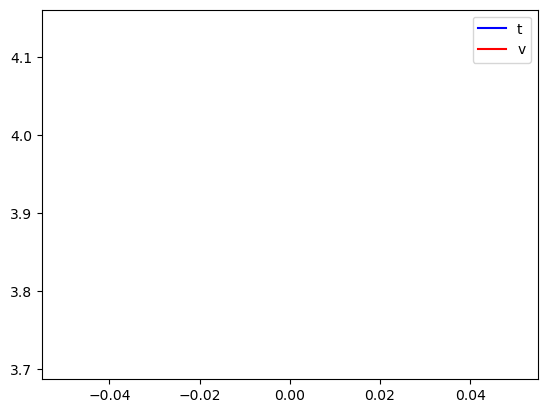

In [40]:
plt.plot(tr_loss,'b-')
plt.plot(val_loss,'r-')
plt.legend(['t','v'])
plt.show()